# Introduction Transition Models
In this notebook, we will train three models which, when taken together, will allow us to identify start and end of transition points in the introduction of an input song. 

In order to do this, we will take advantage of the uniform tempo and phrase structure present in most modern music and in EDM in particular. We will first train a model to predict whether or not the very first beat in a song constitutes the first downbeat of the first phrase at which transitions should begin or end. This will be true the majority of the time, and in this case, we can take jumps of 32 beats to identify the starting points of subsequent phrases; if the first phrase starts at index 0, then the next phrase will start at index 32, then 64, and so on.

There is a small but nonetheless significant proportion of songs (about 25%) where the first downbeat of the first downbeat of the first phrase does not occur on the first beat, e.g. if there is a couple of seconds of silence at the start of MP3 at which madmom has calculated beats, or if there is only a half phrase abbreviated introduction before the vocals of a song begin (and we therefore want our transition to end). We train a second model to deal with this case, which predicts at which bar during the first phrase (i.e. the first 32 beats) the first label should be placed. We then rely on madmom's downbeat prediction to determine the correct downbeat. 

Once the above models are trained, we will be able to identify the timestamps of the phrases in the introduction. The other objective we must meet is to determine whether those phrases should constitute transition points, and, if so, whether they should be start or end points. We will train a model to accomplish this in a manner which is agnostic to phrases, producing probabilities at each bar in the first 256 beats of the song whether it should be a start/end point of the transition. To determine the final transition points, we will use our phrase timestamp information to pick out the transition predictions at the relevant bars. 

In [1]:
import pickle
import numpy as np
import pandas as pd
import librosa
import random

from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate,\
Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv1D,MaxPooling1D,LSTM,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(40)
from sklearn.metrics import confusion_matrix
from scipy import stats


## Data imports
We begin by importing our labelled data and chromagram/spectrogram audio data. We have stored these as pickled dictionaries of dataframes and numpy arrays respectively. We import the information for the test set separately and add it to the main dictionaries.

In [2]:
with open('grams_full.pkl','rb') as f:
    full_grams = pickle.load(f)

with open('labels_dict','rb') as f:
    labels_dict = pickle.load(f)

As seen in the [Data Preparation notebook](1.%20Data%20Preparation.ipynb), the labels look like this:

In [3]:
labels_dict['Chris Lake - Lose My Mind'].head(10)

,Beat Timestamp,Downbeat,Intro Label,Outro Label
0,0.03,3.0,Start,NaN
1,0.51,4.0,NaN,NaN
2,0.99,1.0,NaN,NaN
3,1.47,2.0,NaN,NaN
4,1.95,3.0,NaN,NaN
5,2.43,4.0,NaN,NaN
6,2.91,1.0,NaN,NaN
7,3.39,2.0,NaN,NaN
8,3.87,3.0,NaN,NaN
9,4.35,4.0,NaN,NaN


We define some helper functions for processing this data.

In [4]:
def get_ohs(df):
    """Given a labelled bar/beats input, appends columns with binary
        indicators at each beat, with 1 at the appropriate transition
        points and 0 otherwise.
        
        Args:
            df: Bar/beats dataframe with 'Start' and 'End' transition 
                labels in intro and outro
        
        Returns:
            df_copy: Copy of the dataframe with four columns of binary
                labels appended: Incoming Start, Incoming End, Outgoing
                Start, Outgoing End
        """
    df_copy = df.copy(deep=True)
    
    df_copy['Incoming Start'] = df_copy['Intro Label'].apply(
        lambda x: int('Start' in str(x)))
    df_copy['Incoming End'] = df_copy['Intro Label'].apply(
        lambda x: int('End' in str(x)))
    df_copy['Outgoing Start'] = df_copy['Outro Label'].apply(
        lambda x: int('Start' in str(x)))
    df_copy['Outgoing End'] = df_copy['Outro Label'].apply(
        lambda x: int('End' in str(x)))
    
    df_copy = df_copy.drop(['Intro Label','Outro Label'],axis=1)
    return df_copy


def get_slices(gram,frames):
    """Utility function for slicing a spectrogram/chromagram according
        to frames.
        
        Args:
            gram: Spectrogram or chromagram numpy array
            frames: indices at which to slice array
            
        Returns:
            List of array slices
        """
    return [gram[frames[i]:frames[i+1]] for i in range(len(frames)-1)]

print('Example one-hot output:')
get_ohs(labels_dict['Chris Lake - Lose My Mind']).head(10)

Example one-hot output:


,Beat Timestamp,Downbeat,Incoming Start,Incoming End,Outgoing Start,Outgoing End
0,0.03,3.0,1,0,0,0
1,0.51,4.0,0,0,0,0
2,0.99,1.0,0,0,0,0
3,1.47,2.0,0,0,0,0
4,1.95,3.0,0,0,0,0
5,2.43,4.0,0,0,0,0
6,2.91,1.0,0,0,0,0
7,3.39,2.0,0,0,0,0
8,3.87,3.0,0,0,0,0
9,4.35,4.0,0,0,0,0


We will be feeding the audio features into our models as a sequence of four-beat slices. For each model, we will perform 1D convolution over slices four beats long of the concatenated chromagram/spectrogram numpy arrays, before feeding the resulting representations through a Bidirectional LSTM and performing the various classification tasks using the LSTM hidden state outputs. To prepare the data for this model architecture, we need to slice the spectrogram and chromagram arrays into slices representing the four-beat chunks, using the beat timestamps in the labels to do so. We also need to truncate/pad the slices so they are of a uniform size.

In [5]:
def truncate_pad(outputs,length):
    """Truncates or pads gram slices to be of input length
        
        Args: 
            outputs: length two list containing chromagram and spectrogram 
                inputs, i.e. list of four-beat slices
            length: axis 0 length of output of each slice
        
        Returns:
            length two list of truncated/padded chromagrams and spectrograms
    """
    chromagram,spectrogram = outputs
    
    size = spectrogram.shape[0]
    #We convert the spectrogram power values to db and divide by -80 
    #so that all values are between 0 and 1
    spectrogram = librosa.power_to_db(spectrogram.T, ref=np.max).T/-80.0
    
    
    if size>=length:
        return [x[:length] for x in [chromagram,spectrogram]]
    else:
        zeros_x = length-size
        zeros_chromagram = np.zeros((zeros_x,12))
        zeros_spectrogram = np.zeros((zeros_x,128))
        
        return [np.concatenate([chromagram,zeros_chromagram],axis = 0).astype(np.float32),
               np.concatenate([spectrogram,zeros_spectrogram],axis = 0).astype(np.float32)]

We slice the chromagrams into chunks of length 175 frames. With a sampling rate of 22050 and a hop length of 256, a four-beat slice of length 175 frames is equivalent to a BPM of ~118: 

In [6]:
hops_per_sec = 22050/256
slice_length = 175
slice_length_in_sec = slice_length/hops_per_sec
print('Equivalent BPM for 175-frame slice:',60/(slice_length_in_sec/4))

Equivalent BPM for 175-frame slice: 118.125


For BPMs higher than 118, this will mean that the slices will need to be padded, and lower BPMs will be truncated. However, the vast majority of our population is of a BPM higher than 118, as the standard tempo range for house music is approximately 122 to 130, meaning that not much information will be lost across the full population. 

In [7]:
gram_slices_tp = {}
gram_slice_times = {}
for song in [x for x in labels_dict if x in full_grams]:
    grams = full_grams[song]
    full_gram_shape = grams[0].shape[0]
    
    tags = labels_dict[song]
    tags['Frame'] = librosa.time_to_frames(tags.values[:,0],sr=22050,hop_length=256)
    
    if tags.shape[0]%4==0:
        indices = [i*4 for i in range(tags.shape[0]//4)]
    else:
        indices = [i*4 for i in range(1+tags.shape[0]//4)]
    frames = tags.values[indices,-1].astype(np.int32).tolist()
    if full_gram_shape not in frames:
        frames.append(full_gram_shape)
    
    times = tags.values[indices,0].tolist()
    gram_slice_times[song] = times
    
    chromagrams,spectrograms = [get_slices(gram,frames) for gram in grams]
    
    #We check to make sure there are no empty slices, and add zeros at the start and end
    non_zero_inds = [x for x in range(len(spectrograms)) if spectrograms[x].shape[0]>0]
    
    chromagrams = [chromagrams[i] for i in non_zero_inds]
    chromagrams = [np.zeros((slice_length,12))]+chromagrams+[np.zeros((slice_length,12))]
    
    spectrograms = [spectrograms[i] for i in non_zero_inds]
    spectrograms = [np.zeros((slice_length,128))]+spectrograms+[np.zeros((slice_length,128))]
    
    #We now perform the truncation/padding
    gram_slices_tp[song] = list(zip(*[truncate_pad(x,slice_length) \
                                      for x in zip(*[chromagrams,spectrograms])]))

## Start Classifier
As described above, our first model to train will make a binary prediction of whether the first beat of the song is also the first downbeat of the first phrase. We will perform 1D convolution over slices four beats long of the concatenated chromagram/spectrogram numpy arrays, before feeding the resulting representations through an LSTM. For the Start Classifier, the hidden state of the first and ninth slice (i.e., the first bar of the first and second phrase if the first bar of the first phrase starts on the first beat) are then concatenated and passed through a feed-forward network to make the final binary classification. We look at the first and ninth beat to provide the model with more information on the wider context of the introduction of the song.
### Data Preparation
Before we train the model we need to extract the appropriate labels for each input song. We will define a positive label to be a song where the first beat is **not** the start of the first phrase.

In [8]:
start_classifier_labels = {}
first_label_indices = {}
ohs_dict = {}
for song in gram_slices_tp:
    tags = labels_dict[song]
    ohs = get_ohs(tags)
    ohs_dict[song] = ohs
    
    ohs_starts = ohs[ohs['Incoming Start']+ohs['Incoming End']>=1]

    first_label_index = ohs_starts.index[0]
    first_label_indices[song] = first_label_index

    start_classifier_labels[song] = int(first_label_index!=0)


We can see that there are a total of 282 songs out of our full population of 1,146 where the first phrase does not start on the first beat:

In [9]:
sum(start_classifier_labels.values())

282

Next we split the data into training, validation, and test sets. Since the data is imbalanced, we want to make sure there are enough positive examples in the validation set for it to be useful. This validation and test set will be used throughout this notebook and in the Outros notebook, so we save them to pickled files.

In [10]:
maxes = [0 for _ in range(100)]

while maxes.count(0) >= 70:
    vad_set = random.sample(list(gram_slices_tp),100)
    maxes = [start_classifier_labels[song] for song in vad_set]
    
test_set = random.sample([x for x in gram_slices_tp if x not in vad_set],100)

with open('sc_vad_set.pkl','wb') as f:
    pickle.dump(vad_set,f)    

with open('sc_test_set.pkl','wb') as f:
    pickle.dump(test_set,f)    


train_set = [x for x in gram_slices_tp if x not in vad_set and x not in test_set]

We are now ready to prepare the data for input into the model.

In [11]:
def get_start_classifier_inputs(song):
    """Takes a song as input and returns stacked and concatenated
        array slices representing the first 48 beats of the song.
    """
    chromagrams,spectrograms = gram_slices_tp[song]
    
    #We offset the input by one as the zero padding at the beginning
    #is not necessary for this model
    chromagrams_inp = np.stack(chromagrams[1:13])
    spectrograms_inp = np.stack(spectrograms[1:13])
    
    return np.concatenate([chromagrams_inp,spectrograms_inp],axis = -1)

In [12]:
sc_train_input = np.stack([get_start_classifier_inputs(song) for song in train_set])
sc_train_target = np.array([start_classifier_labels[song] for song in train_set])

sc_vad_input = np.stack([get_start_classifier_inputs(song) for song in vad_set])
sc_vad_target = np.array([start_classifier_labels[song] for song in vad_set])

sc_test_input = np.stack([get_start_classifier_inputs(song) for song in test_set])
sc_test_target = np.array([start_classifier_labels[song] for song in test_set])

### Model definition
The definition of the model is split into two parts: the 1D convolution of the gram slices, and the passing of the resulting vector through a bidirectional LSTM. The convolution model passes the slices through two 1D convolution/max pooling layers, and the LSTM model feeds the output for each slice through two feedforward layers before the Bidirectional LSTM. The LSTM hidden states of the first and ninth bar are concatenated and passed through two more feedforward layers to a single output for binary classification.

In [13]:
sc_seq_len = 12

In [14]:
sc_gram_in = Input((slice_length,140),name = 'sc_analysis_in')

sc_conv_bar_c = Conv1D(filters = 4,kernel_size = 11,activation = 'relu',strides = 3)
sc_pool_bar_c = MaxPooling1D(pool_size = 2,strides = 2)
sc_bar_out_c = BatchNormalization()(sc_pool_bar_c(sc_conv_bar_c(sc_gram_in)))

sc_conv_bar_2_c = Conv1D(filters = 4,kernel_size = 2,activation = 'relu',strides = 2)
sc_pool_bar_2_c = MaxPooling1D(pool_size = 1,strides =1)
sc_bar_out_2_c = BatchNormalization()(sc_pool_bar_2_c(sc_conv_bar_2_c(sc_bar_out_c)))

sc_bar_out_c_flat = Flatten()(sc_bar_out_2_c)
sc_gram_model = Model(sc_gram_in,sc_bar_out_c_flat)

In [15]:
sc_seq_gram_input = Input((sc_seq_len,slice_length,140))

sc_gram_flat = Lambda(lambda x: K.reshape(x,(-1,slice_length,140)))(sc_seq_gram_input)

sc_conv = sc_gram_model(sc_gram_flat)

sc_conv_seq = Lambda(lambda x: K.reshape(x,(-1,sc_seq_len,sc_conv.shape[-1])))(sc_conv)

sc_conv_dense = Dense(24,activation='tanh')(Dropout(rate=0.5)(sc_conv_seq))
sc_conv_dense_2 = Dense(16,activation='tanh')(Dropout(rate=0.5)(sc_conv_dense))

sc_lstm_out = Bidirectional(
    LSTM(24,return_sequences=True,recurrent_dropout = 0.5,dropout=0.5))(sc_conv_dense_2)

sc_first_bar_out = Lambda(lambda x: x[:,:,0])(sc_lstm_out)
sc_first_phrase_out = Lambda(lambda x: x[:,:,8])(sc_lstm_out)
sc_first_out = Concatenate(axis=-1)([sc_first_bar_out,sc_first_phrase_out])
sc_dense_1 = Dense(16,activation='tanh')(Dropout(rate=0.5)(sc_first_out))
sc_out = Dense(1,activation='sigmoid')(Dropout(rate=0.3)(sc_dense_1))
sc_final_model = Model(sc_seq_gram_input,sc_out)


### Model training
We are now ready to train the model. Since our dataset is imbalanced, we will use a weighted binary crossentropy loss function.

In [16]:
def weighted_binary_crossentropy( y_true, y_pred, weight= 4) :
    y_true = tf.cast(y_true,tf.float32)
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

In [17]:
sc_adam_opt = tf.keras.optimizers.Adam(lr = 2e-4)

sc_final_model.compile(optimizer = sc_adam_opt, 
                       loss = weighted_binary_crossentropy,
                       weighted_metrics = ['accuracy'])

We train the model for an initial 75 epochs, then implement early stopping based on best performance on the validation set.

In [18]:
sc_final_model.fit(sc_train_input,sc_train_target,batch_size = 32,epochs = 75,
                             validation_data = (sc_vad_input,sc_vad_target),verbose = 0)

sc_es = EarlyStopping(restore_best_weights=True,monitor='val_weighted_acc',patience=30)

sc_final_model.fit(sc_train_input,sc_train_target,batch_size = 32,epochs = 300,
                             validation_data = (sc_vad_input,sc_vad_target),
                             callbacks=[sc_es],verbose = 0)



In [19]:
print('Training performance:')
sc_final_model.evaluate(sc_train_input,sc_train_target)

Training performance:
30/30 [==============================] - 1s 20ms/step - loss: 1.0160 - accuracy: 0.8360


[1.0160419940948486, 0.8359621167182922]

In [20]:
print('Validation performance:')
sc_final_model.evaluate(sc_vad_input,sc_vad_target)

Validation performance:
4/4 [==============================] - 0s 15ms/step - loss: 1.3412 - accuracy: 0.8000


[1.3411630392074585, 0.800000011920929]

In [21]:
print('Test performance:')
sc_final_model.evaluate(sc_test_input,sc_test_target)

Test performance:
4/4 [==============================] - 0s 12ms/step - loss: 0.9812 - accuracy: 0.8500


[0.981203019618988, 0.8500000238418579]

We can examine performance in the validation set and test set by looking at confusion matrices.

In [22]:
sc_vad_pred = sc_final_model.predict(sc_vad_input)[:,0]
confusion_matrix(sc_vad_target,np.round(sc_vad_pred))

array([[64,  5],
       [15, 16]])

In [23]:
sc_test_pred = sc_final_model.predict(sc_test_input)[:,0]
confusion_matrix(sc_test_target,np.round(sc_test_pred))

array([[68,  7],
       [ 8, 17]])

## Start Bar Finder
Once we have identified songs which do not have their first phrase begin on the first beat, we need to determine where their first phrase does begin. We will do this using a similar approach to that used for the Start Classifier, with the model architecture being mostly the same. The difference will be in the training task; above, we performed simple binary classification, but now we will be performing categorical classification across the first eight 'bars' (more specifically, four beat segments; we cannot guarantee that they correspond to bars which start on the 1 downbeat) of the song. Along the same lines as the Start Classifier, we will concatenate the hidden state outputs of the entire second phrase with those of the first phrase to provide additional context.

### Data Preparation
As above, we need to begin by extracting the appropriate training labels for our data. We are going to look at the full first two phrases (64 beats) this time, rather than just the first 48 beats.

In [24]:
sbf_seq_len = 16

In [25]:
start_bar_finder_labels = {}
for song in gram_slices_tp:
    ohs = ohs_dict[song]
    indices = [i*4 for i in range(tags.shape[0]//4)]
    ohs_slices = [ohs.values[indices[i]:indices[i+1],-4:] for i in range(sbf_seq_len)]
    slice_labels = [np.max(slce,axis = 0) for slce in ohs_slices if slce.shape[0]!=0]
    marks = [i for i in range(len(slice_labels)) if slice_labels[i][0]==1 or slice_labels[i][1]==1]
    
    first_mark = marks[0]
    start_bar_finder_labels[song] = np.identity(8)[first_mark % 8]

In [26]:
def get_start_bar_finder_inputs(song):
    """Takes a song as input and returns stacked and concatenated
        array slices representing the first 64 beats of the song.
    """
    chromagrams,spectrograms = gram_slices_tp[song]
    
    #We offset the input by one as the zero padding at the beginning
    #is not necessary for this model
    chromagrams_inp = np.stack(chromagrams[1:17])
    spectrograms_inp = np.stack(spectrograms[1:17])
    
    return np.concatenate([chromagrams_inp,spectrograms_inp],axis = -1)

In [27]:
sbf_train_input = np.stack([get_start_bar_finder_inputs(song) for song in train_set])
sbf_train_target = np.stack([start_bar_finder_labels[song] for song in train_set])

sbf_vad_input = np.stack([get_start_bar_finder_inputs(song) for song in vad_set])
sbf_vad_target = np.stack([start_bar_finder_labels[song] for song in vad_set])

sbf_test_input = np.stack([get_start_bar_finder_inputs(song) for song in test_set])
sbf_test_target = np.stack([start_bar_finder_labels[song] for song in test_set])

We are more interested in the examples which were positive in the start classifier training, so we will use the start classifier targets to generating training sample weights for this model. There are still a significant proportion of positive examples which start within the first bar, so we weight those examples at 0.6 and the remaining examples at 1.

In [28]:
sbf_train_weights = 0.002 + 0.6*sc_train_target  + \
                0.4*((np.argmax(sbf_train_target,axis=-1)>0).astype(np.int32))
sbf_vad_weights = 0.002 + 0.6*sc_vad_target + \
                0.4*((np.argmax(sbf_vad_target,axis=-1)>0).astype(np.int32))
sbf_test_weights = 0.002 + 0.6*sc_test_target + \
                0.4*((np.argmax(sbf_test_target,axis=-1)>0).astype(np.int32))

### Model Definition

In [29]:
sbf_gram_in = Input((slice_length,140),name = 'sbf_analysis_in')

sbf_conv_bar_c = Conv1D(filters = 6,kernel_size = 11,activation = 'relu',strides = 3)
sbf_pool_bar_c = MaxPooling1D(pool_size = 2,strides = 2)
sbf_bar_out_c = BatchNormalization()(sbf_pool_bar_c(sbf_conv_bar_c(sbf_gram_in)))

sbf_conv_bar_2_c = Conv1D(filters = 4,kernel_size = 2,activation = 'relu',strides = 2)
sbf_pool_bar_2_c = MaxPooling1D(pool_size = 1,strides =1)
sbf_bar_out_2_c = BatchNormalization()(sbf_pool_bar_2_c(sbf_conv_bar_2_c(sbf_bar_out_c)))

sbf_bar_out_c_flat = Flatten()(sbf_bar_out_2_c)
sbf_gram_model = Model(sbf_gram_in,sbf_bar_out_c_flat)

In [30]:
sbf_gram_input = Input((sbf_seq_len,slice_length,140))
sbf_gram_flat = Lambda(lambda x: K.reshape(x,(-1,slice_length,140)))(sbf_gram_input)

sbf_conv = sbf_gram_model(sbf_gram_flat)

sbf_conv_seq = Lambda(lambda x: K.reshape(x,(-1,sbf_seq_len,sbf_conv.shape[-1])))(sbf_conv)


sbf_conv_dense = Dense(32,activation='tanh')(Dropout(rate=0.6)(sbf_conv_seq))
sbf_conv_dense_2 = Dense(20,activation='tanh')(Dropout(rate=0.6)(sbf_conv_dense))

sbf_lstm_out = Bidirectional(
    LSTM(24,return_sequences=True,recurrent_dropout = 0.5,dropout=0.5))(
    sbf_conv_dense_2)
sbf_dense_1 = Dense(24,activation='tanh')(Dropout(rate=0.15)(sbf_lstm_out))


sbf_first_phrase = Lambda(lambda x: x[:,:8,:])(sbf_dense_1)
sbf_second_phrase = Lambda(lambda x: x[:,8:,:])(sbf_dense_1)

sbf_dense_1_attention = Concatenate(axis=-1)([sbf_first_phrase,sbf_second_phrase])

sbf_dense_2 = Dense(16,activation='tanh')(Dropout(rate=0.2)(sbf_dense_1_attention))
sbf_dense_3 = Dense(8,activation='tanh')(Dropout(rate=0.1)(sbf_dense_2))

sbf_out = Dense(1)(Dropout(rate=0.1)(sbf_dense_3))
sbf_out_soft = Activation('softmax')(Lambda(lambda x: x[:,:,0])(sbf_out))
sbf_final_model = Model(sbf_gram_input,sbf_out_soft)

### Model Training

In [31]:
sbf_adam_opt = tf.keras.optimizers.Adam(lr = 4e-4)

sbf_final_model.compile(optimizer = sbf_adam_opt, 
                        loss = 'categorical_crossentropy',
                        weighted_metrics = ['categorical_accuracy'])

We once again use early stopping to identify the model with the best performance on the validation set.

In [32]:
sbf_final_model.fit(sbf_train_input,sbf_train_target,batch_size = 32,
                    epochs = 80,sample_weight = sbf_train_weights,
               validation_data = (sbf_vad_input,sbf_vad_target,sbf_vad_weights),
                    verbose = 0)

sbf_es = EarlyStopping(restore_best_weights=True,monitor='val_loss',patience=30)
sbf_final_model.fit(sbf_train_input,sbf_train_target,batch_size = 32,
                    epochs = 300,sample_weight = sbf_train_weights,
               validation_data = (sbf_vad_input,sbf_vad_target,sbf_vad_weights),
                   callbacks = [sbf_es],verbose = 0)


In [33]:
print('Training performance:')
sbf_final_model.evaluate(sbf_train_input,sbf_train_target,sample_weight=sbf_train_weights)

Training performance:
30/30 [==============================] - 1s 25ms/step - loss: 0.2603 - categorical_accuracy: 0.5787


[0.2602640390396118, 0.5787070989608765]

In [34]:
print('Validation performance:')
sbf_final_model.evaluate(sbf_vad_input,sbf_vad_target,sample_weight=sbf_vad_weights)

Validation performance:
4/4 [==============================] - 0s 18ms/step - loss: 0.2324 - categorical_accuracy: 0.7250


[0.23235656321048737, 0.7250000238418579]

In [35]:
print('Test performance:')
sbf_final_model.evaluate(sbf_test_input,sbf_test_target,sample_weight=sbf_test_weights)

Test performance:
4/4 [==============================] - 0s 16ms/step - loss: 0.3341 - categorical_accuracy: 0.4975


[0.3341290354728699, 0.4975000321865082]

In [36]:
sbf_vad_pred = sbf_final_model.predict(sbf_vad_input)
sbf_test_pred = sbf_final_model.predict(sbf_test_input)

## Introduction Transition Timing
Now that we have identified the first downbeat of the song, we need to determine the timing(s) of when the transition could begin and end. We will once again train a model using 1D convolution on four-beat chunks input into a bidirectional LSTM. This time, however, we will train the model across the whole introduction rather than just the first phrase or two. Since some longer songs have introductions that can last a couple of minutes, we will look at the first 256 beats (or 64 'bars') of each song. The training labels will be binary labels on each bar of whether the transition should start or end on that bar.
### Data Preparation
We need to extract the binary start/end labels from the labelled beats for each song.

In [37]:
tm_seq_len = 64

In [38]:
timing_model_labels = {}
for song in gram_slices_tp:
    ohs = ohs_dict[song]
    indices = [i*4 for i in range(tags.shape[0]//4)]
    ohs_slices = [ohs.values[indices[i]:indices[i+1],-4:-2] for i in range(tm_seq_len)]
    slice_labels = [np.max(slce,axis = 0) for slce in ohs_slices if slce.shape[0]!=0]
    slice_labels = [np.array([0,0])] + slice_labels
    while len(slice_labels) < tm_seq_len + 1:
        slice_labels.append(np.array([0,0]))
    timing_model_labels[song] = slice_labels

In [39]:
def get_timing_model_inputs(song):
    """Takes a song as input and returns stacked and concatenated
        array slices representing the first 256 beats of the song.
    """
    chromagrams,spectrograms = gram_slices_tp[song]
    
    chromagrams_inp = np.stack(chromagrams[:tm_seq_len+1])
    spectrograms_inp = np.stack(spectrograms[:tm_seq_len+1])
    
    if chromagrams_inp.shape[0] < tm_seq_len + 1:
        padding_needed = tm_seq_len + 1 - chromagrams_inp.shape[0]
        zeros_pad_chromagram = np.zeros((padding_needed,slice_length,12))
        chromagrams_inp = np.concatenate([chromagrams_inp,zeros_pad_chromagram],
                                        axis = 0)
        
        zeros_pad_spectrogram = np.zeros((padding_needed,slice_length,128))
        spectrograms_inp = np.concatenate([spectrograms_inp,zeros_pad_spectrogram],
                                        axis = 0)
        
    return np.concatenate([chromagrams_inp,spectrograms_inp],axis = -1).astype(np.float32)

We need to implement training weights to ensure that the model is focusing its training in a useful way. The labels for a song typically look something like this, with the first column a binary label meaning a transition can start at that point, and the second column a binary label meaning a transition can end at that point:

In [40]:
#Example of training labels for the first few phrases of a song
example_df = pd.DataFrame(np.stack(timing_model_labels['Chris Lake - Lose My Mind']),
            columns = ['Transition Start Label','Transition End Label'])

example_df.head(42)

,Transition Start Label,Transition End Label
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,1.0,0.0


With our Start Classifier and Start Bar Finder models trained above, we have identified where the first phrase in the song begins. Subsequent phrases begin every 8 bars after that first phrase. We only need to determine whether a transition should begin or end at the start of each phrase, and not in any of the bars in between. We therefore will set up our sample weighting so that the model focuses on being correct at the transition points themselves, and not worrying too much about whether it is correct about the fact that there is no transition in the middle of a phrase. We do still want to identify when the transition should fully complete, so we also put a stronger weight on the first couple of [0, 0] labels after the final 'End' label.

In [41]:
def get_single_weight(i,sums,other_weight=0.01):
    """Determines training weights for transition timing model. 
        All bars with positive labels are set at 1, along with the 
        bars at the first two phrases after the transition is complete.
        
        Args:
            i: Index in sliced label input
            sums: List of sum of labels at each index.
            other_weight: Scaling weight for less important inputs
            
        Returns:
            Scaled weight (either 1 or other_weight)
    """
    factor = other_weight/(1-other_weight)
    if i < 8:
        return (int(sums[i]!=0)+factor)/(1+factor)
    elif i < 16:
        return (int(sums[i]!=0 or sums[i-8]!=0)+factor)/(1+factor)
    else:
        return (int(sums[i]!=0 or sums[i-8]!=0 or sums[i-16]!=0)+factor)/(1+factor)

def get_weights(song):
    """Wrapper function for get_single_weight function to apply
        to full label input for a song"""
    labels = timing_model_labels[song]
    sums = [np.sum(label) for label in labels]
    return [get_single_weight(i,sums) for i in range(len(sums))]

In [42]:
tm_train_input = np.stack([get_timing_model_inputs(song) for song in train_set]).astype('float32')
tm_train_target = np.stack([timing_model_labels[song] for song in train_set]).astype('float32')
tm_train_weights = np.stack([get_weights(song) for song in train_set]).astype('float32')

tm_vad_input = np.stack([get_timing_model_inputs(song) for song in vad_set]).astype('float32')
tm_vad_target = np.stack([timing_model_labels[song] for song in vad_set]).astype('float32')
tm_vad_weights = np.stack([get_weights(song) for song in vad_set]).astype('float32')

tm_test_input = np.stack([get_timing_model_inputs(song) for song in test_set]).astype('float32')
tm_test_target = np.stack([timing_model_labels[song] for song in test_set]).astype('float32')
tm_test_weights = np.stack([get_weights(song) for song in test_set]).astype('float32')


### Model Definition

In [43]:
tm_gram_in = Input((slice_length,140),name = 'tm_analysis_in')

tm_conv_bar_c = Conv1D(filters = 16,kernel_size = 11,activation = 'relu',strides = 3)
tm_pool_bar_c = MaxPooling1D(pool_size = 2,strides = 2)
tm_bar_out_c = BatchNormalization()(tm_pool_bar_c(tm_conv_bar_c(tm_gram_in)))

tm_conv_bar_2_c = Conv1D(filters = 8,kernel_size = 2,activation = 'relu',strides = 2)
tm_pool_bar_2_c = MaxPooling1D(pool_size = 1,strides =1)
tm_bar_out_2_c = BatchNormalization()(tm_pool_bar_2_c(tm_conv_bar_2_c(tm_bar_out_c)))

tm_bar_out_c_flat = Flatten()(tm_bar_out_2_c)
tm_gram_model = Model(tm_gram_in,tm_bar_out_c_flat)

In [44]:
tm_gram_input = Input((tm_seq_len+1,slice_length,140))
tm_gram_flat = Lambda(lambda x: K.reshape(x,(-1,slice_length,140)))(tm_gram_input)

tm_conv = tm_gram_model(tm_gram_flat)

tm_conv_seq = Lambda(lambda x: K.reshape(x,(-1,tm_seq_len+1,tm_conv.shape[-1])))(tm_conv)

tm_conv_dense = Dense(48,activation='tanh')(Dropout(rate=0.4)(tm_conv_seq))
tm_conv_dense_2 = Dense(32,activation='tanh')(Dropout(rate=0.4)(tm_conv_dense))

tm_lstm_out = Bidirectional(LSTM(
    48,return_sequences=True,recurrent_dropout = 0.45,dropout=0.45))(tm_conv_dense_2)
tm_dense_1 = Dense(16,activation='tanh')(Dropout(rate=0.4)(tm_lstm_out))
tm_out = Dense(2,activation='sigmoid')(Dropout(rate=0.3)(tm_dense_1))
tm_final_model = Model(tm_gram_input,tm_out)

### Model Training

In [45]:
tm_adam_opt = tf.keras.optimizers.Adam(lr = 2e-4)

tm_final_model.compile(optimizer = tm_adam_opt, loss = 'binary_crossentropy',
                    weighted_metrics = ['accuracy'],sample_weight_mode='temporal')

In [46]:
tm_final_model.fit(tm_train_input,tm_train_target,batch_size = 16,
                sample_weight=tm_train_weights,epochs = 75,
                   validation_data = (tm_vad_input,tm_vad_target,tm_vad_weights),
                  verbose = 0)

tm_es = EarlyStopping(restore_best_weights=True,monitor='val_loss',patience=20)
tm_final_model.fit(tm_train_input,tm_train_target,batch_size = 16,
                sample_weight=tm_train_weights,epochs = 200,
                   validation_data = (tm_vad_input,tm_vad_target,tm_vad_weights),
                  callbacks = [tm_es], verbose = 0)

In [47]:
print('Training performance:')
tm_final_model.evaluate(tm_train_input,tm_train_target,sample_weight=tm_train_weights)

Training performance:
30/30 [==============================] - 3s 90ms/step - loss: 0.0182 - accuracy: 0.5919


[0.018191229552030563, 0.5919362306594849]

In [48]:
print('Validation performance:')
tm_final_model.evaluate(tm_vad_input,tm_vad_target,sample_weight=tm_vad_weights)

Validation performance:
4/4 [==============================] - 0s 62ms/step - loss: 0.0165 - accuracy: 0.6082


[0.016483861953020096, 0.6081527471542358]

In [49]:
print('Test performance:')
tm_final_model.evaluate(tm_test_input,tm_test_target,sample_weight=tm_test_weights)

Test performance:
4/4 [==============================] - 0s 59ms/step - loss: 0.0276 - accuracy: 0.5567


[0.027625715360045433, 0.556698739528656]

We can examine what the resulting predictions look like for our labels example above. We can see that, as desired, the model is focussing on predicting the positive labels correctly. As long as we can predict the location of the first phrase correctly, we will be able to identify the correct start/end points by taking jumps of 32 beats. 

In [50]:
example_pred = np.round(
    tm_final_model.predict(
        tm_train_input[[train_set.index('Chris Lake - Lose My Mind')]]),2)[0]

example_df = pd.concat([example_df,
                        pd.DataFrame(example_pred,
                                     columns = ['Start Probability','End Probability'])],axis=1)
example_df.head(42)

,Transition Start Label,Transition End Label,Start Probability,End Probability
0,0.0,0.0,0.96,0.03
1,1.0,0.0,0.97,0.03
2,0.0,0.0,0.97,0.02
3,0.0,0.0,0.96,0.02
4,0.0,0.0,0.96,0.02
5,0.0,0.0,0.96,0.02
6,0.0,0.0,0.95,0.03
7,0.0,0.0,0.96,0.03
8,0.0,0.0,0.95,0.03
9,1.0,0.0,0.95,0.03


We can define a function to extract Start/End labels based on the probabilities predicted by the model at a certain timestep. 

In [51]:
def get_labels(prob_pair,threshold = 0.4):
    """Generates labels based on the transition timing model
        output at a single timestep.
        
        Args:
            prob_pair: tuple containing the (start prob,end prob)
                predicted by the model
            threshold: Threshold probability at which a label 
                will be generated
        Returns:
            Label of either Start, End, Start/End, or nan
    """
    start_prob,end_prob = prob_pair
    if start_prob > threshold:
        if end_prob > threshold:
            return 'Start/End'
        else:
            return 'Start'
    elif end_prob > threshold:
        return 'End'
    else:
        return np.nan


Now, depending on the probability predicted by the Start Classifier, we can determine the appropriate labels. Since the Start Classifier predicts this is a negative example (i.e. the first downbeat of the first phrase does fall on the first beat), we can take the first beat of the first bar as the starting point and use this to generate labels. We skip the first bar because this is the zero padding we included in our data processing.

In [52]:
sc_example_prob = np.round(
                    sc_final_model.predict(
                       sc_train_input[[train_set.index('Chris Lake - Lose My Mind')]]),2)[0][0]
print('Example Start Classifier probability: ' ,sc_example_prob)

Example Start Classifier probability:  0.05


In [53]:
example_df['Predicted Label'] = np.nan
intro_onbeat_start_inds = [1+8*j for j in range(8)]
for ind in intro_onbeat_start_inds:
    example_df.iloc[ind,-1] = get_labels(example_df.iloc[ind,[-3,-2]])
example_df.head(42)

,Transition Start Label,Transition End Label,Start Probability,End Probability,Predicted Label
0,0.0,0.0,0.96,0.03,NaN
1,1.0,0.0,0.97,0.03,Start
2,0.0,0.0,0.97,0.02,NaN
3,0.0,0.0,0.96,0.02,NaN
4,0.0,0.0,0.96,0.02,NaN
5,0.0,0.0,0.96,0.02,NaN
6,0.0,0.0,0.95,0.03,NaN
7,0.0,0.0,0.96,0.03,NaN
8,0.0,0.0,0.95,0.03,NaN
9,1.0,0.0,0.95,0.03,Start


## Full Introduction Model
We will now extend our single example above to generalise the Transition Model - with the three separate components now trained, we can combine them into an end-to-end process which, given beat and downbeat timestamps alongside chromagram and spectrogram data, can label transition points in the introduction of a song. We will construct this process and evaluate overall performance on the test set. 

The logic used is as follows:

- If the Start Classifier has a predicted probability of less than 0.5, then the first beat is the first transition point. 
- If the Start Classifier has a predicted probability of 0.5 or greater, then the prediction of the Start Bar Finder is used to identify the bar which contains the first transition point. The beat in that bar which has a Madmom downbeat index prediction of 1 is the first transition point. 
- Subsequent transition points are labelled every 32 beats based on the output of the transition timing model.

In [54]:
tm_test_pred = tm_final_model.predict(tm_test_input)

In [55]:
test_song_pred_info = {}
for i,song in enumerate(test_set):
    start_classifier_prob = sc_test_pred[i]
    
    slice_times = gram_slice_times[song]
    timing_model_probs = tm_test_pred[i]
    if start_classifier_prob < 0.5:
        phrase_bar_inds = [8*j for j in range(8)]
        start_bar_downbeat_index = 0
        phrase_times = [slice_times[j] for j in phrase_bar_inds]
    else:
        start_bar_index = np.argmax(sbf_test_pred[i])
        correct_start_bar_index = np.argmax(sbf_test_target[i])
        start_bar_beat_index = start_bar_index * 4
        
        tags = labels_dict[song]
        start_bar_tags = tags.iloc[start_bar_beat_index:start_bar_beat_index+4]
        start_bar_downbeat_index = start_bar_tags[start_bar_tags['Downbeat']==1].index[0]
        
        phrase_bar_inds = [start_bar_index+8*j for j in range(-8,8)]
        phrase_bar_inds = [x for x in phrase_bar_inds if x< 64 and x>=0]
        
        phrase_beat_inds = [start_bar_downbeat_index + j*32 for j in range(-8,8)]
        phrase_beat_inds = [x for x in phrase_beat_inds if x>=0 and x<=256]
        phrase_times = tags.values[phrase_beat_inds,0].tolist()
        
    phrase_ind_probs = tm_test_pred[i][phrase_bar_inds,:]
    phrase_labels = [get_labels(pair) for pair in phrase_ind_probs]
        
        
    info = list(zip(*(phrase_times,phrase_labels)))
    info_df = pd.DataFrame(info,columns = ['Beat Timestamp','Predicted Intro Label'])
    test_song_pred_info[song] = info_df

The resulting labels for a song after this process is complete look something like this:

In [56]:
song = "Brohug - If I'm Wrong"
test_song_pred_info[song]

,Beat Timestamp,Predicted Intro Label
0,0.01,Start
1,15.36,Start
2,30.72,End
3,46.08,NaN
4,61.44,NaN
5,76.80,NaN
6,92.17,NaN
7,107.53,NaN


We can join on the original labels to compare, and see that the prediction for this song is correct.

In [57]:
tags_label = labels_dict[song].loc[:,['Beat Timestamp','Intro Label']]
tags_label = tags_label[tags_label['Intro Label'].apply(lambda x: x in ['Start'])]
                                   
test_song_pred_info[song].merge(labels_dict[song].loc[:,['Beat Timestamp','Intro Label']].dropna(),
                              on = 'Beat Timestamp',how='outer').sort_values('Beat Timestamp')

,Beat Timestamp,Predicted Intro Label,Intro Label
0,0.01,Start,Start
1,15.36,Start,Start
2,30.72,End,End
3,46.08,NaN,NaN
4,61.44,NaN,NaN
5,76.80,NaN,NaN
6,92.17,NaN,NaN
7,107.53,NaN,NaN


We can check across the full test set to see overall performance, determining for each song whether the initial downbeat prediction is correct, and whether the timing predictions are generally correct by looking at the number of labels created. 

In [58]:
downbeat_right = []
downbeat_diffs = []
length_right = []
length_diffs = []
exact = []
first_downbeats = {}
for song in test_set:
    tags_label = labels_dict[song].loc[:,['Beat Timestamp','Intro Label']].dropna(
            ).reset_index(drop = True)
    pred_df = test_song_pred_info[song].dropna()
    pred_df.columns = ['Beat Timestamp','Intro Label']
    first_downbeats[song] = pred_df.values[0,0]
    if pred_df.shape[0]>0:
        if tags_label.values[0,0] == pred_df.values[0,0]:
            downbeat_right.append(song)
        else:
            downbeat_diffs.append(tags_label.values[0,0] - pred_df.values[0,0])
    if tags_label.shape[0] == pred_df.shape[0]:
        length_right.append(song)
        if tags_label.equals(pred_df):
            exact.append(song)
        #We will relax the exact check slightly by allowing 'Start/End' to be 
        #equal to 'Start' or 'End'
        elif tags_label.replace('Start/End','Start').equals(pred_df.replace('Start/End','Start')):
            exact.append(song)
        elif tags_label.replace('Start/End','End').equals(pred_df.replace('Start/End','End')):
                exact.append(song)
    else:
        length_diffs.append((song,tags_label.shape[0] - pred_df.shape[0]))

        
with open('first_downbeat_predictions.pkl','wb') as f:
    pickle.dump(first_downbeats,f)
    
print('Number of songs with downbeat prediction correct:',len(downbeat_right))
print('Number of songs with same number of transition points:',len(length_right))
print('Number of songs which are exactly correct:', len(exact))

Number of songs with downbeat prediction correct: 76
Number of songs with same number of transition points: 61
Number of songs which are exactly correct: 49


We can see that our process is exactly correct for 49 out of 100 songs in the test set. Songs with an incorrect downbeat prediction have definitely been given incorrect labels by our model, as all the phrases will be in the wrong place; this means that 24 out of the 100 songs are guaranteed to be incorrect. The remaining 27 songs have a correct downbeat prediction but incorrect timing on the transitions according to our labels (i.e. they end the transition on the right phrase grid but at different phrases or with the wrong label). However, labelling transition timing is a subjective task, and although we tried to be as consistent as possible there is some variation in how a song's introduction can be labelled. We therefore conducted a manual review of these 27 songs and found that 18 of them had a transition timing which, while it did not exactly match our labelling, would still be acceptable and form a seamless mix if used. Two such examples are below. 

In the first example, the manual labels say that the transition can either start or end at the beginning of the second phrase, or end at the beginning of the third phrase. The predicted labels only identified the transition which ends at the second phrase. However, this transition is still valid, so while it does not capture the full possibility of the labelled transition we have counted it as correct. 

In [59]:
ex_song_1 = 'Axwell & Ingrosso - How Do You Feel Right Now'
print('Predicted Label:')
print(test_song_pred_info[ex_song_1].dropna())
print('\nManual Label:')
print(labels_dict[ex_song_1].loc[:,['Beat Timestamp','Intro Label']].dropna())

Predicted Label:
   Beat Timestamp Predicted Intro Label
0            0.02                 Start
1           15.02                   End

Manual Label:
    Beat Timestamp Intro Label
0             0.02       Start
32           15.02   Start/End
64           30.02         End


In the second example, the model has failed to predict an ending point for the transition. However, we can make a straightforward inference that, if there is no end point predicted, the end must come after the final 'Start' label. With this logic we can infer the correct transition labelling for this song and several others.

In [60]:
ex_song_2 = 'Sultan & Shepard - Head Over Heels'
print('Predicted Label:')
print(test_song_pred_info[ex_song_2].dropna())
print('\nManual Label:')
print(labels_dict[ex_song_2].loc[:,['Beat Timestamp','Intro Label']].dropna())

Predicted Label:
   Beat Timestamp Predicted Intro Label
0            0.04                 Start
1           15.52                 Start

Manual Label:
    Beat Timestamp Intro Label
0             0.04       Start
32           15.52       Start
64           31.01         End


Including these 18 leaves us overall with 67 songs out of the 100 total in our test set for which our models were able to produce high-quality transition timing labels. It is clear that labelling the initial downbeat correctly is the most crucial task in this process. If that was achieved, then our overall success rate was 67 out of 76, or 88%. Of the 76 songs with their first downbeat labelled correctly, 62 were correctly predicted as having their first downbeat on the very first beat of the song. If this is not the case, then identifying the specific point at which the first downbeat occurs is a more difficult task. It relies not only on finding the correct bar where the first phrase begins, but also on identifying the correct downbeat within that bar. We can examine which part of the process was responsible for the incorrect result for our 24 songs in the Sankey diagram below.
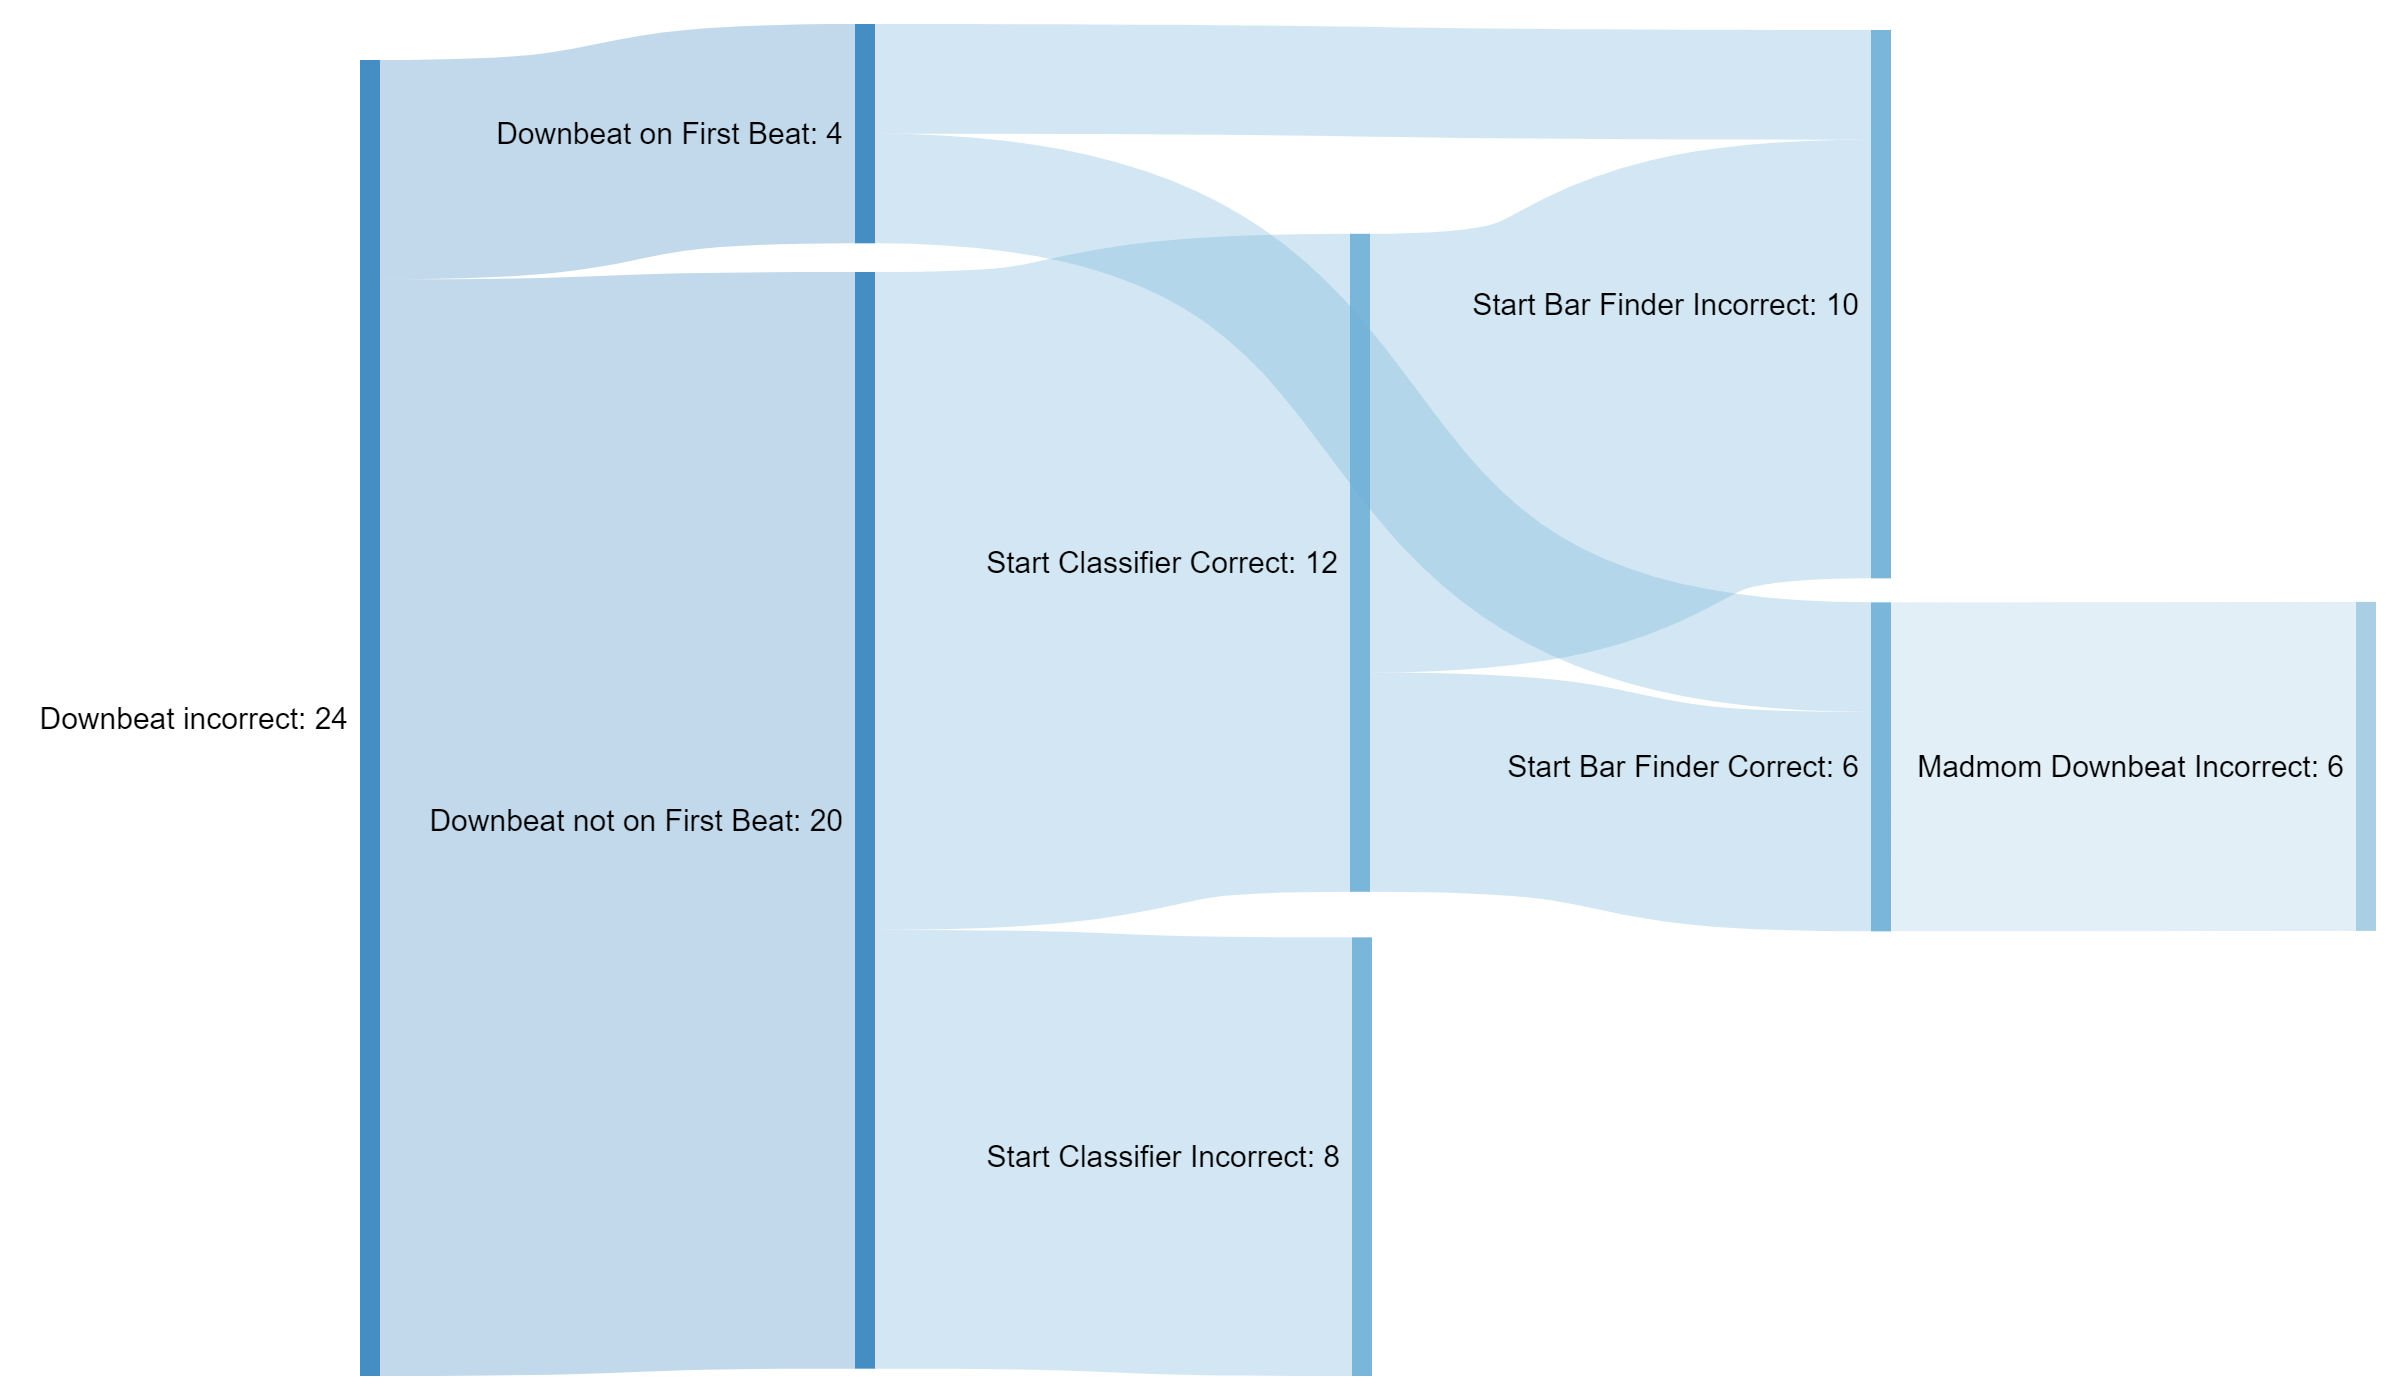